<a href="https://colab.research.google.com/github/bb426/image_segmentation/blob/main/DeepLab_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load datasets

In [3]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:30<00:00, 94.9MB/s]


In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1_000
NUM_VAL_IMAGES = 50

In [5]:
train_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[-NUM_TRAIN_IMAGES:]
val_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[-NUM_TRAIN_IMAGES:]

In [6]:
def read_images(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1

    return image

In [7]:
def load_data(image_list, mask_list):
    image = read_images(image_list)
    mask = read_images(mask_list, mask=True)
    return image, mask

In [8]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [9]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

In [10]:
print(train_dataset)
print(val_dataset)

<BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>


## Define the DeepLab model

In [11]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [12]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[-2]), interpolation='bilinear')(x)

    out1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out1, out6, out12, out18])
    output = convolution_block(x, kernel_size=1)
    return output

In [13]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=model_input)
    
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = DilatedSpatialPyramidPooling(x)
    
    input_a = layers.UpSampling2D(size=(image_size // 4 // x.shape[1], 
                                        image_size // 4 // x.shape[2]),
                                  interpolation='bilinear')(x)
    input_b = resnet50.get_layer('conv2_block3_2_relu').output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size=(image_size // x.shape[1], 
                                  image_size // x.shape[2]),
                            interpolation='bilinear')(x)
    
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding='same')(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [14]:
model = DeeplabV3(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

## Train the defiend model

In [18]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
250/250 [==============================] - 335s 1s/step - loss: 0.5597 - accuracy: 0.8216 - val_loss: 0.8278 - val_accuracy: 0.7529
Epoch 2/5
250/250 [==============================] - 327s 1s/step - loss: 0.5105 - accuracy: 0.8385 - val_loss: 1.0056 - val_accuracy: 0.7157
Epoch 3/5
250/250 [==============================] - 326s 1s/step - loss: 0.4780 - accuracy: 0.8490 - val_loss: 0.9729 - val_accuracy: 0.7357
Epoch 4/5
250/250 [==============================] - 324s 1s/step - loss: 0.4348 - accuracy: 0.8632 - val_loss: 0.9523 - val_accuracy: 0.7401
Epoch 5/5
250/250 [==============================] - 327s 1s/step - loss: 0.4096 - accuracy: 0.8716 - val_loss: 0.8781 - val_accuracy: 0.7586


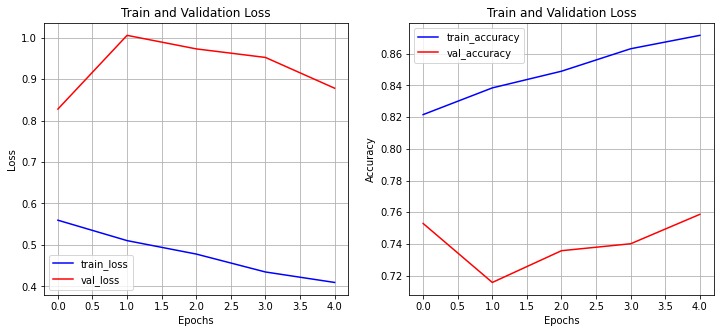

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(loss, color='blue', label='train_loss')
ax1.plot(val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(accuracy, color='blue', label='train_accuracy')
ax2.plot(val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## Inference

In [24]:
colormap = loadmat('./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat')['colormap']
colormap *= 100
colormap = colormap.astype(np.uint8)

In [25]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

In [26]:
def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    
    for i in range(n_classes):
        idx = mask == i
        r[idx] = colormap[i, 0]
        g[idx] = colormap[i, 0]
        b[idx] = colormap[i, 0]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [35]:
def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

In [36]:
def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()

In [37]:
def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_images(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib([image_tensor, overlay, prediction_colormap], figsize=(18, 14))

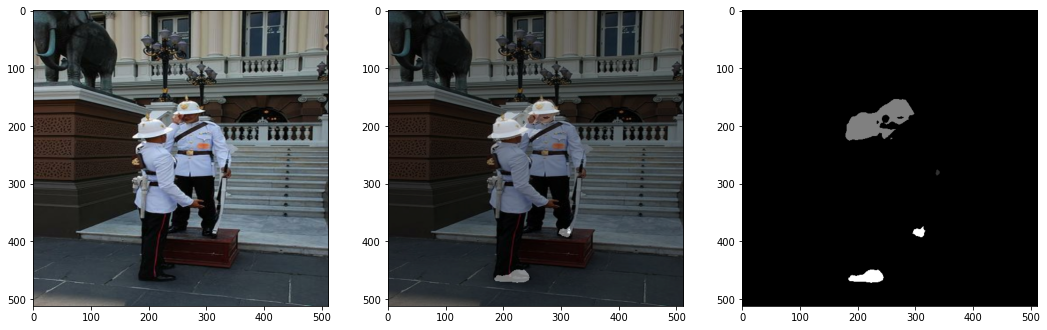

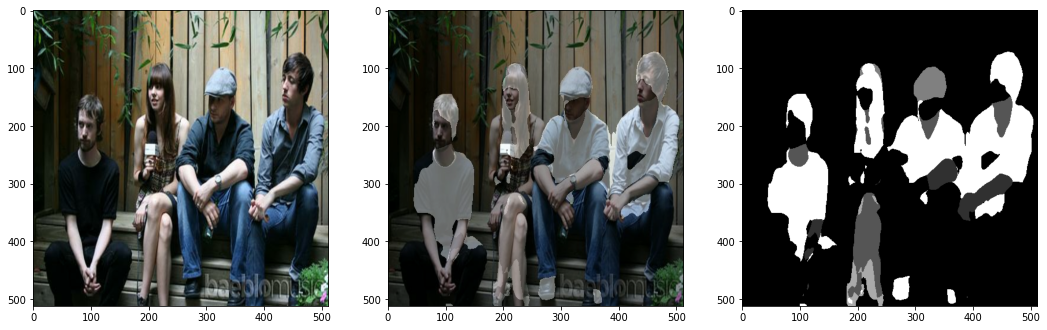

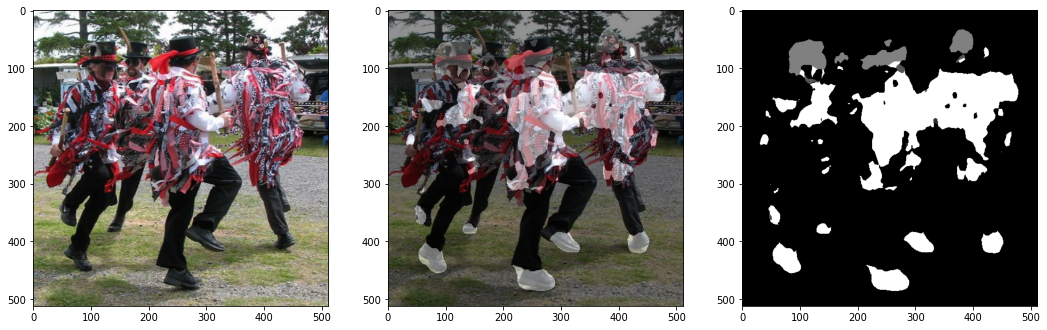

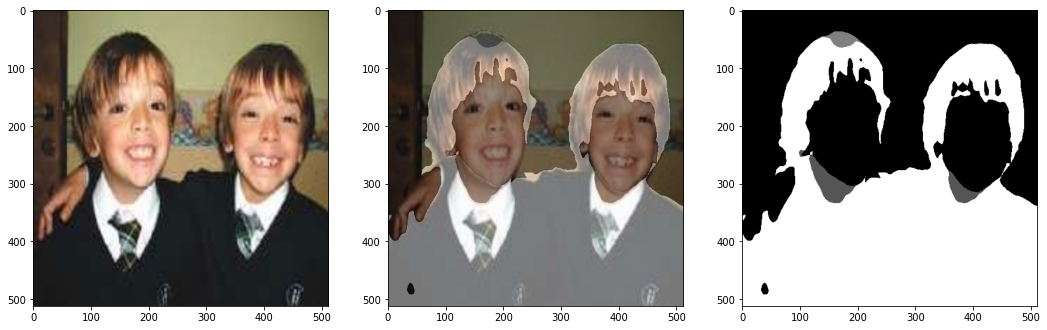

In [38]:
plot_predictions(train_images[:4], colormap, model=model)